In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random

# Sampling from two different gaussian distributions

In [2]:
mu_centered, sigma_centered = 0, 0.1
s_normal_centered = np.random.normal(mu_centered, sigma_centered, 1000)

mu_shifted, sigma_shifted = 10, 0.2
s_normal_shifted = np.random.normal(mu_shifted, sigma_shifted, 1000)

μ_centered =-0.0009009738751356317
σ_centered =0.09923493388946779
μ_shifted =10.000949271846961
σ_shifted =0.2039423451705121


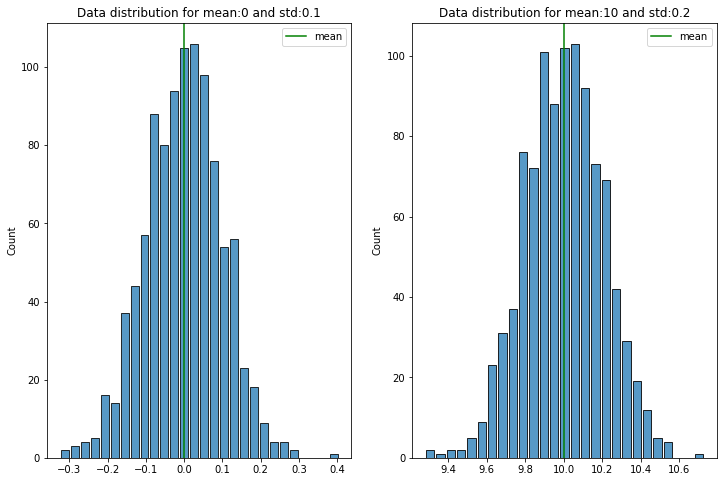

In [3]:
fig, axis = plt.subplots(1,2,figsize=(12,8))

sns.histplot(s_normal_centered, ax=axis[0], shrink=0.8, stat='count').set(title=f"Data distribution for mean:{mu_centered} and std:{sigma_centered}")
axis[0].axvline(s_normal_centered.mean(), color='green', label='mean')
axis[0].legend()

sns.histplot(s_normal_shifted, ax=axis[1], shrink=0.8, stat='count').set(title=f"Data distribution for mean:{mu_shifted} and std:{sigma_shifted}")
axis[1].axvline(s_normal_shifted.mean(), color='green', label='mean')
axis[1].legend()

print(f'μ_centered ={s_normal_centered.mean()}')
print(f'σ_centered ={s_normal_centered.std()}')
print(f'μ_shifted ={s_normal_shifted.mean()}')
print(f'σ_shifted ={s_normal_shifted.std()}')


# Data sets generation

In [4]:
# sample 90% from centered dataset
centered_dist = random.sample(list(s_normal_centered), 900)
normal_points = ["no" for e in centered_dist]

# sample 10% from shifted dataset 
shifted_dist = random.sample(list(s_normal_shifted), 100)
outliers = ["yes" for e in shifted_dist]

numbers = centered_dist + shifted_dist 
labels = normal_points + outliers 

# Create df with two columns (number, label)
df = pd.DataFrame({'number': numbers, 'label_gt': labels})
df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   number            1000 non-null   float64
 1   label_gt          1000 non-null   object 
 2   numeric_label_gt  1000 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


In [6]:
df.head()

,number,label_gt,numeric_label_gt
0,-0.196629,no,1
1,0.028745,no,1
2,0.069117,no,1
3,-0.009147,no,1
4,0.086205,no,1


In [7]:
df.tail()

,number,label_gt,numeric_label_gt
995,9.857499,yes,-1
996,10.040988,yes,-1
997,10.211470,yes,-1
998,9.812666,yes,-1
999,9.825628,yes,-1


In [8]:
df.describe()

,number,numeric_label_gt
count,1000.000000,1000.0000
mean,0.999014,0.8000
std,3.007561,0.6003
min,-0.324286,-1.0000
25%,-0.063891,1.0000
50%,0.014525,1.0000
75%,0.091272,1.0000
max,10.521595,1.0000


In [9]:
# The frac keyword argument specifies the fraction of rows to return in the random sample, 
# so frac=1 means to return all rows in random order
df = df.sample(frac=1)

# Isolation Forest

In [10]:
# Train IF, K-means, RF, SVDD? 
from sklearn.ensemble import IsolationForest

model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
model.fit(df[['number']])

df['scores']=model.decision_function(df[['number']])
df['anomaly']=model.predict(df[['number']])
df["anomaly"] = np.where(df['anomaly']== -1, "yes", "no")
print(df['anomaly'].value_counts())
(df["anomaly"] == df["label_gt"]).value_counts()

no     900
yes    100
Name: anomaly, dtype: int64


True     946
False     54
dtype: int64

## Using Grid Search to find the best set of parameters for IF

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

my_scoring_func = make_scorer(f1_score)
parameters = {'n_estimators':[10,30,50,80,100], 
            'max_features':[0.1,0.2,0.3,0.4,1.0], 
            'contamination' : [0.1,0.2,0.3]
            }
isolation_forest =  IsolationForest(max_samples='auto')
search = GridSearchCV(isolation_forest, parameters,  scoring=my_scoring_func)
search.fit(df[['number']], df[['numeric_label_gt']])

GridSearchCV(estimator=IsolationForest(),
             param_grid={'contamination': [0.1, 0.2, 0.3],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 1.0],
                         'n_estimators': [10, 30, 50, 80, 100]},
             scoring=make_scorer(f1_score))

In [26]:
result_search_df = pd.DataFrame(search.cv_results_)
best_estimators = result_search_df[["mean_test_score", "std_test_score", "params"]].sort_values(by=["mean_test_score"], ascending=False).head()
print(f"Best estimator parameters: {best_estimators.iloc[0]['params']}")

Best estimator parameters: {'contamination': 0.1, 'max_features': 0.4, 'n_estimators': 50}


In [27]:
optimal_forest = search.best_estimator_
pred = optimal_forest.predict(df[['number']])

h = (pred == df['numeric_label_gt']).value_counts()
h

True     965
False     35
Name: numeric_label_gt, dtype: int64

In [14]:
# Visualize results
df

,number,label_gt,numeric_label_gt,scores,anomaly
82,-0.086916,no,1,0.146511,no
15,-0.145478,no,1,0.118966,no
0,-0.196629,no,1,0.040110,no
415,-0.114255,no,1,0.140030,no
681,-0.011446,no,1,0.187981,no
...,...,...,...,...,...
600,0.064456,no,1,0.180814,no
264,0.109237,no,1,0.158684,no
578,0.135507,no,1,0.137128,no
276,0.017785,no,1,0.191458,no


# Sampling from two different distributions: Gaussian and Poisson

In [15]:
mu_gau, sigma_gau = 0, 0.1
s_normal = np.random.normal(mu_gau, sigma_gau, 1000)

s_poisson = np.random.poisson(5, 1000)

μ_centered =-0.0011442474490064468
σ_centered =0.09834399005647161
μ_shifted =4.911
σ_shifted =2.166813097615943


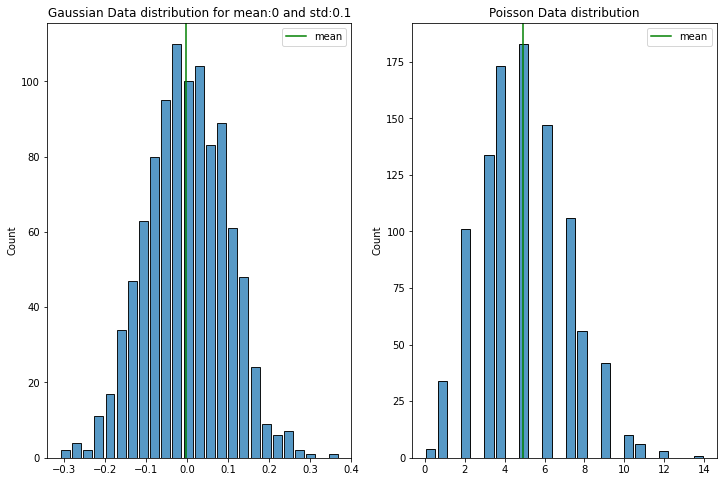

In [16]:
fig, axis = plt.subplots(1,2,figsize=(12,8))

sns.histplot(s_normal, ax=axis[0], shrink=0.8, stat='count').set(title=f"Gaussian Data distribution for mean:{mu_gau} and std:{sigma_gau}")
axis[0].axvline(s_normal.mean(), color='green', label='mean')
axis[0].legend()

sns.histplot(s_poisson, ax=axis[1], shrink=0.8, stat='count').set(title=f"Poisson Data distribution")
axis[1].axvline(s_poisson.mean(), color='green', label='mean')
axis[1].legend()

print(f'μ_centered ={s_normal.mean()}')
print(f'σ_centered ={s_normal.std()}')
print(f'μ_shifted ={s_poisson.mean()}')
print(f'σ_shifted ={s_poisson.std()}')

In [84]:
# sample 90% from centered dataset
gaus_dist = random.sample(list(s_normal), 900)
normal_points = ["no" for e in gaus_dist]

# sample 1% from shifted dataset 
poisson_dist = random.sample(list(s_poisson), 100)
outliers = ["yes" for e in poisson_dist]

numbers = gaus_dist + poisson_dist 
labels = normal_points + outliers 

# Create df with two columns (number, label)
df = pd.DataFrame({'number': numbers, 'label_gt': labels})
df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

df = df.sample(frac=1)

In [85]:
# Train IF
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
model.fit(df[['number']])

df['scores']=model.decision_function(df[['number']])
df['anomaly']=model.predict(df[['number']])
df["anomaly"] = np.where(df['anomaly']== -1, "yes", "no")
print(df['anomaly'].value_counts())
print(f"predictions: \n {(df['anomaly'] == df['label_gt']).value_counts()}")

no     912
yes     88
Name: anomaly, dtype: int64
predictions: 
 True     982
False     18
dtype: int64


# Sampling from two different distributions: Gaussian and standard_cauchy

In [28]:
mu_gau, sigma_gau = 0, 0.1

s_normal = np.random.normal(mu_gau, sigma_gau, 1000)

s_std_cauchy = np.random.standard_cauchy(1000)
# truncate distribution so it plots well
s_std_cauchy = s_std_cauchy[(s_std_cauchy>-25) & (s_std_cauchy<25)]
len(s_std_cauchy)

980

μ_centered =0.0018640331536105453
σ_centered =0.09836919324118122
μ_shifted =-0.010132270476756003
σ_shifted =4.13173690830271


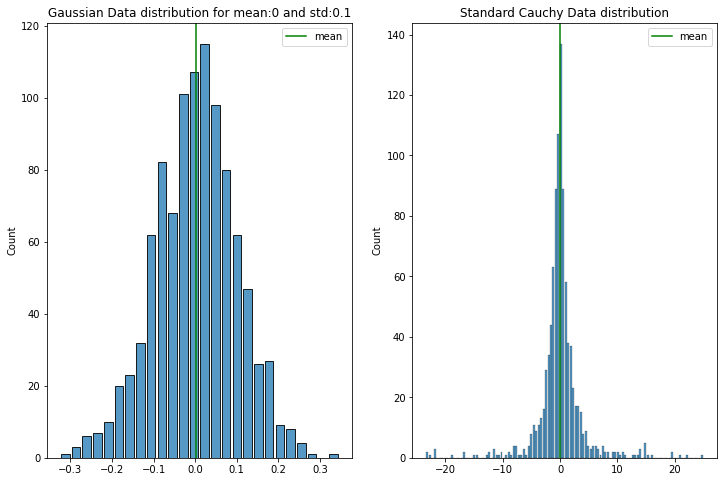

In [29]:
fig, axis = plt.subplots(1,2,figsize=(12,8))

sns.histplot(s_normal, ax=axis[0], shrink=0.8, stat='count').set(title=f"Gaussian Data distribution for mean:{mu_gau} and std:{sigma_gau}")
axis[0].axvline(s_normal.mean(), color='green', label='mean')
axis[0].legend()

sns.histplot(s_std_cauchy, ax=axis[1], shrink=0.8, stat='count').set(title=f"Standard Cauchy Data distribution")
axis[1].axvline(s_std_cauchy.mean(), color='green', label='mean')
axis[1].legend()

print(f'μ_centered ={s_normal.mean()}')
print(f'σ_centered ={s_normal.std()}')
print(f'μ_shifted ={s_std_cauchy.mean()}')
print(f'σ_shifted ={s_std_cauchy.std()}')

In [99]:
# sample 90% from centered dataset
gaus_dist = random.sample(list(s_normal), 900)
normal_points = ["no" for e in gaus_dist]

# sample 10% from shifted dataset 
cauchy_dist = random.sample(list(s_std_cauchy), 100)
outliers = ["yes" for e in cauchy_dist]

numbers = gaus_dist + cauchy_dist 
labels = normal_points + outliers 

# Create df with two columns (number, label)
df = pd.DataFrame({'number': numbers, 'label_gt': labels})
df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

df = df.sample(frac=1)

In [100]:
# Train IF
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
model.fit(df[['number']])

df['scores']=model.decision_function(df[['number']])
df['anomaly']=model.predict(df[['number']])
df["anomaly"] = np.where(df['anomaly']== -1, "yes", "no")

#print(f"Ground Truth: \n {df['anomaly'].value_counts()}")
#print(f"\n predictions: \n {(df['anomaly'] == df['label_gt']).value_counts()}")

outliers=df.loc[df['anomaly']=="yes"]
outlier_index=list(outliers.index)
#print(outlier_index)

        number    scores
994  -0.630236 -0.164883
997  13.664851 -0.438512
937  -1.122053 -0.208130
938   0.330003 -0.043621
991  -7.239915 -0.385482
..         ...       ...
914   1.258238 -0.205874
139  -0.271233 -0.022440
962  -3.645559 -0.318947
593   0.251928 -0.003391
999  -0.673942 -0.167975

[100 rows x 2 columns]


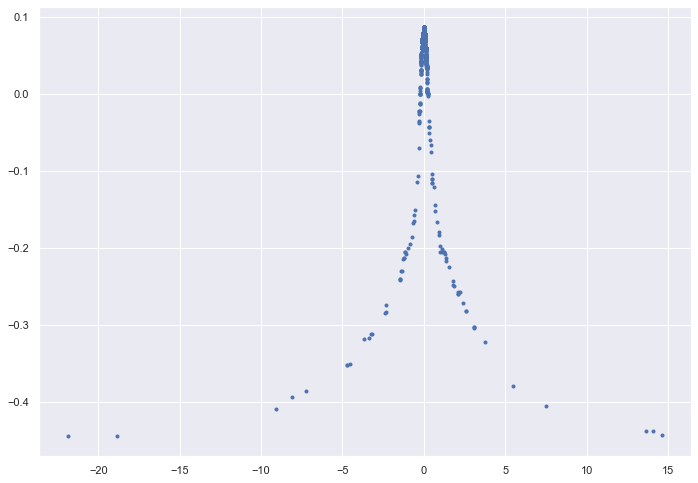

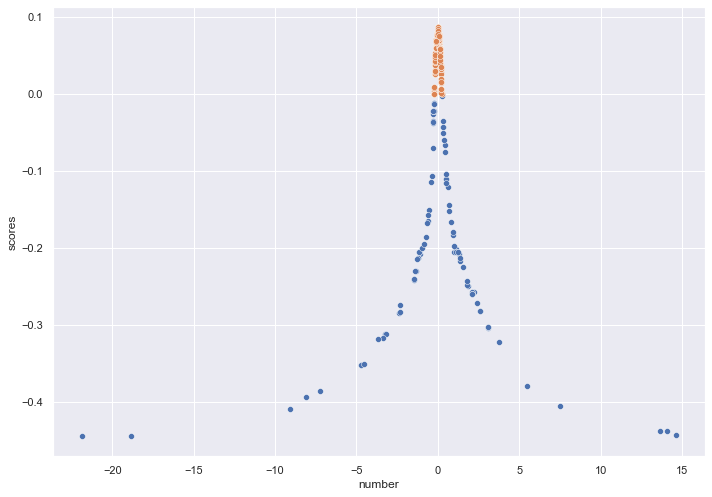

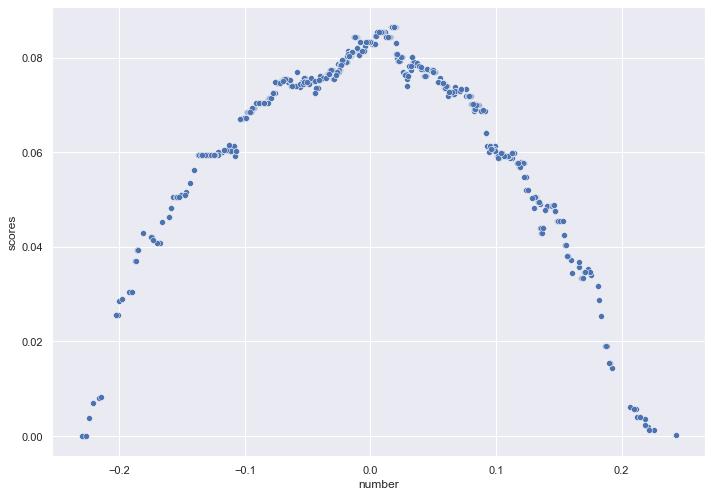

In [101]:
anomaly_detection_visualisation(df)

# Visualization

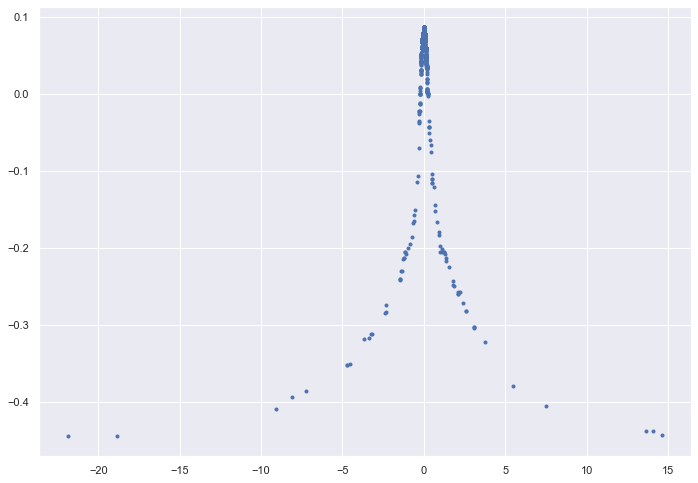

In [102]:
plt.plot(df['number'],df['scores'], '.')

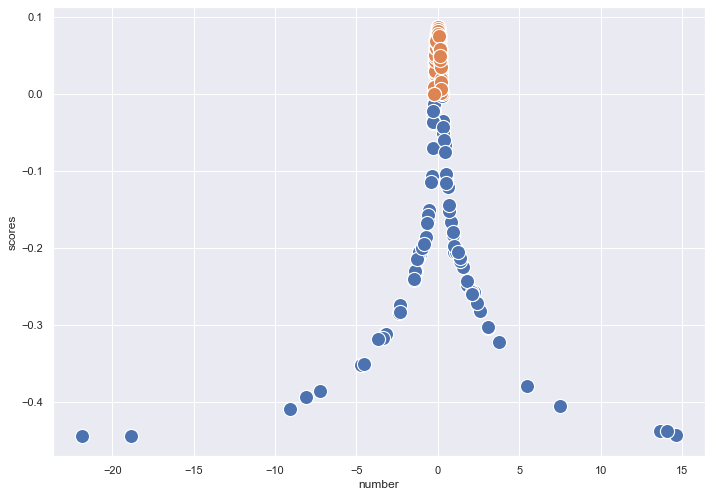

In [103]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
outliers = df[df["anomaly"] == "yes"]
non_outliers = df[df["anomaly"] == "no"]

sns.scatterplot(x=outliers["number"], y= outliers["scores"], s=200, palette='r');
sns.scatterplot(x=non_outliers["number"], y= non_outliers["scores"], s=200, palette='g');

<AxesSubplot:xlabel='number', ylabel='scores'>

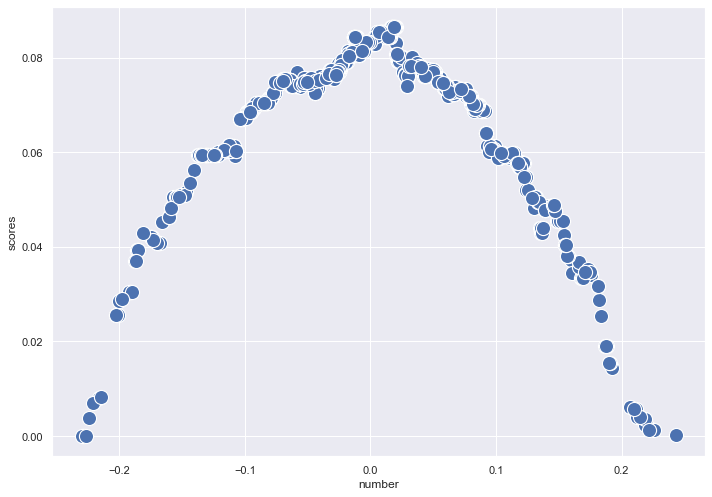

In [104]:
sns.scatterplot(x=non_outliers["number"], y=non_outliers["scores"], s=200, palette='g')

# TODO: function to generate set of datasets 
- functions 
    - fix interval for the two distributions 
    - fix error probability 
    - generate different datasets

In [114]:
def generate_datasets(normal_distribution, error_distribution, error_probability):
    
    # sample 90% from normal dataset
    gaus_dist = random.sample(list(normal_distribution), 900)
    normal_points = ["no" for e in gaus_dist]

    # sample 10% from error dataset 
    cauchy_dist = random.sample(list(error_distribution), 100)
    outliers = ["yes" for e in cauchy_dist]

    numbers = gaus_dist + cauchy_dist 
    labels = normal_points + outliers 

    # Create df with two columns (number, label)
    df = pd.DataFrame({'number': numbers, 'label_gt': labels})
    df["numeric_label_gt"] = np.where(df['label_gt']== "yes", -1, 1)

    # shuffle rows
    df = df.sample(frac=1)

    return df


def train_IF(dataset):
    # Train IF
    model=IsolationForest(n_estimators=50, max_samples='auto', contamination=0.1,max_features=1.0)
    model.fit(dataset[['number']])

    dataset['scores']=model.decision_function(dataset[['number']])
    dataset['anomaly']=model.predict(dataset[['number']])
    dataset["anomaly"] = np.where(dataset['anomaly']== -1, "yes", "no")

    outliers=dataset.loc[dataset['anomaly']=="yes"]
    outlier_index=list(outliers.index)

    return model, dataset

def anomaly_detection_visualisation(df):
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    plt.plot(df['number'],df['scores'], '.')
    plt.title("datapoints and outlier score")
    plt.xlabel("datapoint (number)")
    plt.ylabel("anomaly score")
    outliers = df[df["anomaly"] == "yes"]
    non_outliers = df[df["anomaly"] == "no"]
    
    plt.figure()
    plt.title("outliers and non outliers")
    data = pd.DataFrame({'number': outliers["number"], 'scores': outliers["scores"]})
    sns.scatterplot(x="number", y="scores", data=data, palette='red');

    data = pd.DataFrame({'number': non_outliers["number"], 'scores': non_outliers["scores"]})
    sns.scatterplot(x="number", y= "scores", data=data, palette='green');

    plt.figure()
    plt.title("outliers anomaly score")
    data = pd.DataFrame({'number': non_outliers["number"], 'scores': non_outliers["scores"]})
    sns.scatterplot(x="number", y="scores", data=data, palette='g')

#anomaly_detection_visualisation(df)

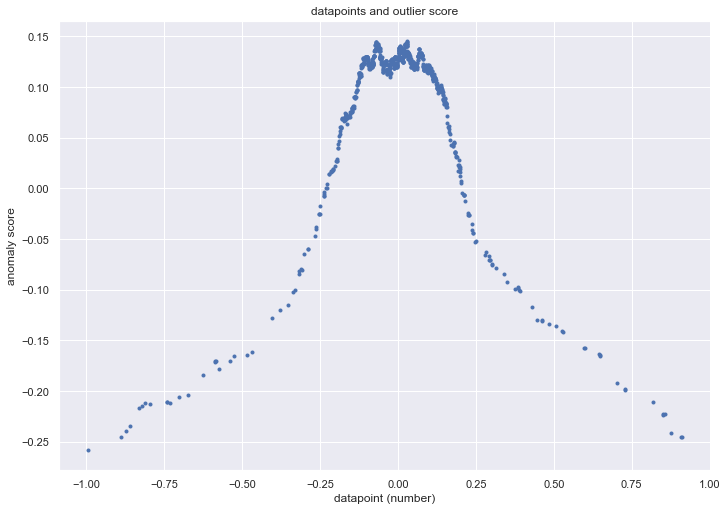

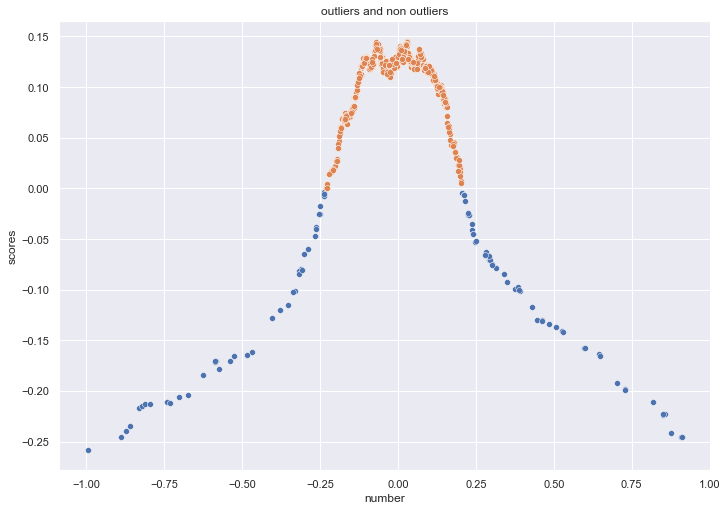

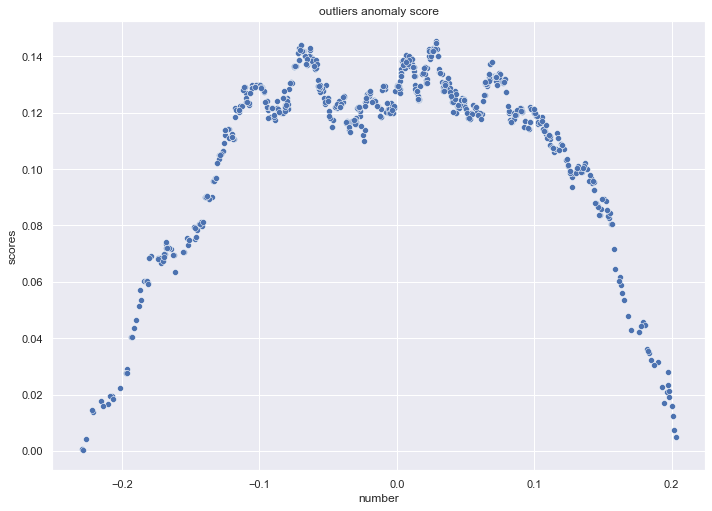

In [115]:
# generate distributions 
mu_gau, sigma_gau = 0, 0.1
normal_distribution = np.random.normal(mu_gau, sigma_gau, 1000)
error_distribution = np.random.standard_cauchy(1000)
# truncate distribution so it plots well
error_distribution = error_distribution[(error_distribution>-1) & (error_distribution<1)]

# generate dataset 
ds1 = generate_datasets(normal_distribution, error_distribution, error_probability=0.1)

# Train IF 
model, ds1_post_det = train_IF(ds1)

# Visualization
anomaly_detection_visualisation(ds1_post_det)